In [1]:
import os
import sys
sys.path.append('../gan/')

import torch
import numpy as np
from torch.utils.data import DataLoader

from dataset import ImageDataset
from model import UnetGenerator
from trainer import Trainer
from config import RANDOM_SEED, DATA_DIR, TRAIN_CONFIG, TRAIN_FRAC
from scheduler import get_gpu_id

In [2]:
config = TRAIN_CONFIG

In [3]:
dataset = ImageDataset(DATA_DIR)
train_size = int(len(dataset) * TRAIN_FRAC)
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, config['train_batch_size'], True)
val_dataloader = DataLoader(val_dataset, config['val_batch_size'], True)

In [4]:
gray, real = train_dataset[0]

In [5]:
import torch.nn as nn
from loguru import logger


class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.config = config
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=3)
        self.fc = nn.Linear(128 * 2 * 2, 1)
        
    def forward(self, x, debug=False):
        def _debug():
            if debug:
                logger.info(x.shape)
        
        x = self.conv1(x)
        _debug()
        x = self.conv2(x)
        _debug()
        x = self.conv3(x)
        _debug()
        x = self.conv4(x)
        _debug()
        x = x.view(x.shape[0], -1)
        _debug()
        x = self.fc(x)
        _debug()
        return x

In [6]:
discriminator = Discriminator(config)
discriminator(real.unsqueeze(0), debug=True)

2020-12-05 04:00:54.150 | INFO     | __main__:_debug:18 - torch.Size([1, 16, 85, 85])
2020-12-05 04:00:54.162 | INFO     | __main__:_debug:18 - torch.Size([1, 32, 28, 28])
2020-12-05 04:00:54.173 | INFO     | __main__:_debug:18 - torch.Size([1, 64, 9, 9])
2020-12-05 04:00:54.182 | INFO     | __main__:_debug:18 - torch.Size([1, 128, 2, 2])
2020-12-05 04:00:54.183 | INFO     | __main__:_debug:18 - torch.Size([1, 512])
2020-12-05 04:00:54.185 | INFO     | __main__:_debug:18 - torch.Size([1, 1])


tensor([[-0.0852]], grad_fn=<AddmmBackward>)

In [7]:
config['lambda'] = 1

In [8]:
import os

import tqdm
import wandb
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable, grad


from config import WANDB_PROJECT, CHECKPOINT_DIR


class Trainer:
    def __init__(self, generator, discriminator, g_optimizer, d_optimizer, train_dataloader, val_dataloader, config=TRAIN_CONFIG):
        self.generator = generator.to(config['device'])
        self.discriminator = discriminator.to(config['device'])
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.config = config
        self.l1_loss = torch.nn.L1Loss()

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader

    def _initialize_wandb(self, project_name=WANDB_PROJECT):
        wandb.init(config=self.config, project=project_name)
        wandb.watch(self.generator)
        wandb.watch(self.discriminator)

    def train(self):
        self.generator.train()
        self.discriminator.train()
#         self._initialize_wandb()

        best_val_loss = np.inf
        ones_label = Variable(torch.ones(self.config['train_batch_size'], 1))
        ones_label = ones_label.to(self.config['device'])
        zeros_label = Variable(torch.zeros(self.config['train_batch_size'], 1))
        zeros_label = zeros_label.to(self.config['device'])

        for epoch in range(self.config['epochs_num']):
            logger.info(f"Epoch {epoch} started...")
            for i, data in tqdm.tqdm(enumerate(self.train_dataloader)):
                sketches, real = data
                sketches = sketches.to(self.config["device"])
                real = real.to(self.config["device"])
                
                # Train discriminator
                g_sample = self.generator(sketches)
                d_fake = self.discriminator(g_sample)
                d_real = self.discriminator(real)
                gradient_penalty = self._compute_gp(real, g_sample)

#                 d_loss_real = self.adv_loss(d_real, ones_label)
#                 d_loss_fake = self.adv_loss(d_fake, zeros_label)
#                 d_loss = d_loss_real + d_loss_fake
                d_loss = torch.mean(d_fake) - torch.mean(d_real)
                d_loss_gp = d_loss + gradient_penalty
                d_loss_gp.backward()
                self.d_optimizer.step()

                self._reset_grad()

                if i % self.config['d_coef'] == 0:
                    # Train Generator
                    g_sample = self.generator(sketches)
                    d_fake = self.discriminator(g_sample)
                    
                    adv_loss = -torch.mean(d_fake)
                    l1_loss = self.l1_loss(g_sample, real)
                    g_loss = adv_loss + self.config["lambda"] * l1_loss
                    g_loss.backward()
                    self.g_optimizer.step()
                    
                    self._reset_grad()

                if i % self.config['log_each'] == 0:
                    val_metrics = self._compute_metrics(self.val_dataloader)
                    val_loss = val_metrics['loss']
                    val_fig = val_metrics['sample_fig']
                    wandb.log({
                        "Adv loss": adv_loss.item(), \
                        "L1 loss": l1_loss.item(),
                        "D loss": d_loss.item(),
                        "Gradient penalty": gradient_penalty,
                        "Val Loss": val_loss, \
                        "Sample": val_fig
                    })
                    plt.clf()

                    if val_loss < best_val_loss:
                        self._save_checkpoint(self.generator, "baseline")
                        best_val_loss = val_loss
        logger.info(f"Training finished. Best validation loss: {best_val_loss}")

    def _compute_metrics(self, dataloader):
        self.generator.eval()
        sketches = []
        real = []
        outputs = []

        for data in dataloader:
            batch_sketches, batch_real = data
            batch_sketches = batch_sketches.to(self.config["device"])
            batch_real = batch_real.to(self.config["device"])
            with torch.no_grad():
                batch_outputs = self.generator(batch_sketches)
            sketches.append(batch_sketches)
            real.append(batch_real)
            outputs.append(batch_outputs)

        sketches = torch.cat(sketches)
        real = torch.cat(real)
        outputs = torch.cat(outputs)
        loss = self.l1_loss(outputs, real).item()
        
        idx = np.random.choice(len(real))
        
        sketch_sample = sketches[idx]
        real_sample = real[idx]
        output_sample = outputs[idx]
        
        fig = self._visualize(sketch_sample, real_sample, output_sample)

        return {"loss": loss, "sample_fig": fig}
    
    @staticmethod
    def _visualize(sketch, real, output):
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))
        ax[0].set_title("Sketch")
        ax[0].imshow(sketch.permute(1, 2, 0).cpu().data)
        ax[1].set_title("Real")
        ax[1].imshow(real.permute(1, 2, 0).cpu().data)
        ax[2].set_title("Predicted")
        ax[2].imshow(output.permute(1, 2, 0).cpu().data)
        return fig

    @staticmethod
    def _save_checkpoint(model, checkpoint_name):
        checkpoint_dir = os.path.join(CHECKPOINT_DIR, wandb.run.id)
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        checkpoint_path = os.path.join(checkpoint_dir, f"{checkpoint_name}.pt")
        torch.save(model.state_dict(), checkpoint_path)
        
    def _reset_grad(self):
        self.generator.zero_grad()
        self.discriminator.zero_grad()
        
    def _compute_gp(self, X, g_sample):
        alpha = torch.rand((self.config["train_batch_size"], 1,
                            1, 1)).to(self.config['device'])  # TODO: (@whiteRa2bit, 2020-09-25) Fix shape
        x_hat = alpha * X.data + (1 - alpha) * g_sample.data
        x_hat.requires_grad = True
        pred_hat = self.discriminator(x_hat)
        gradients = grad(
            outputs=pred_hat,
            inputs=x_hat,
            grad_outputs=torch.ones(pred_hat.size()).to(self.config['device']),
            create_graph=True,
            retain_graph=True,
            only_inputs=True)[0]
        gradient_penalty = self.config['lambda'] * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

        return gradient_penalty


In [9]:
generator = UnetGenerator(config['in_channels'], config['out_channels'], config['num_downs'])
discriminator = Discriminator(config)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=config['g_lr'])
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['g_lr'])

In [10]:
trainer = Trainer(generator, discriminator, g_optimizer, d_optimizer, \
                  train_dataloader, val_dataloader, config)

2020-12-05 04:00:58.051 | INFO     | __main__:train:42 - Epoch 0 started...
0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
0it [00:03, ?it/s]


Error: You must call wandb.init() before wandb.log()

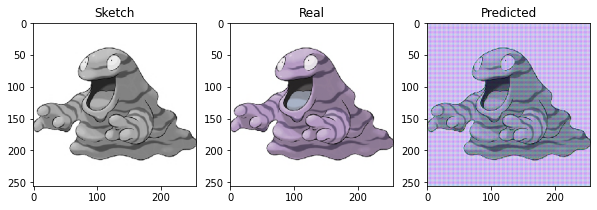

In [11]:
trainer.train()